In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import pymongo as pm
from pymongo import MongoClient
from collections import Counter, defaultdict
from tqdm import tqdm
import seaborn as sns
from pandas.plotting import scatter_matrix

In [9]:
client = MongoClient()
db = client.wyscout

In [10]:
results = db.results01
competitions = db.competitions
players = db.players
#events
ev_all = db.events
ev_nat = db.events_nat
ev_club = db.events_club
ev_it = db.events_Italy
ev_fr = db.events_France
ev_es = db.events_Spain
ev_en = db.events_England
ev_de = db.events_Germany
ev_wc = db.events_World_Cup
ev_eu = db.events_European_Championship
#matches
mt_all = db.matches
mt_nat = db.matches_nat
mt_club = db.matches_club
mt_it = db.matches_Italy
mt_fr = db.matches_France
mt_es = db.matches_Spain
mt_en = db.matches_England
mt_de = db.matches_Germany
mt_wc = db.matches_World_Cup
mt_eu = db.matches_European_Championship

In [11]:
results.find_one()

{'_id': ObjectId('5da399b104f673bbf27304c4'),
 'matchId': 1694428,
 'teamId': 9905,
 'numGoalkeeperLeavingLine': 0,
 'numFreeKick': 23,
 'numPass': 178,
 'numDuel': 96,
 'numOffside': 1,
 'numInterruption': 0,
 'numSaveAttempt': 0,
 'numFoul': 13,
 'numOthersOnTheBall': 29,
 'numShot': 1,
 'numAccuratePass': 145,
 'rateAccuratePass': 0.8146067415730337,
 'meanPrevScore': 1.333333333333333,
 'meanPrevScoreET': 0,
 'meanPrevScoreHT': 0.6666666666666666,
 'meanPrevScoreP': 0,
 'meanPlayerOverall': 38.17391304347826,
 'meanPlayerPotential': 38.91304347826087,
 'numRedCard': 0,
 'finalScore': 1,
 'isWinner': True,
 'numSecondHalfGoals': 0,
 'numYellowCard': 0,
 'numSecondYellowCard': 0}

In [6]:
'''
players_collection = db.players
players = pd.DataFrame(list(players_collection.find()))
matches_collection = db.matches
matches = pd.DataFrame(list(matches_collection.find()))
events_collection = db.events
events = pd.DataFrame(list(events_collection.find()))    
results_collection = db.results
results = pd.DataFrame(list(results_collection.find()))
'''

In [4]:
interestingEvNames = ['Pass', 'Duel', 'Free Kick',  'Others on the ball', 'Shot']
def add_percBallInfo (res_col, ev_col):
    mt_ids_in_res = [e['matchId'] for e in res_col.find({}, {'_id':0, 'matchId':1})]
    for mId in tqdm(mt_ids_in_res):
        tm_ids_in_match = [e['teamId'] for e in res_col.find({'matchId': mId}, {'_id':0, 'teamId':1})]
        all_mt_ev = [e for e in ev_col.find( { 'matchId': int(mId) } ) ]
        
        for tId in tm_ids_in_match:
            all_tm_ev = [e for e in all_mt_ev if e['teamId'] == int(tId)]
            interesting_ev_cnt = len([e for e in all_tm_ev if e['eventName'] in interestingEvNames])
            oppHalfField_ev_cnt = len([e for e in all_tm_ev if e['positions'][0]['x']>50])

            percBallPoss = interesting_ev_cnt/len(all_mt_ev) * 100
            percOppHalfField = oppHalfField_ev_cnt/len(all_mt_ev) * 100
            
            res_col.update_one({'matchId': mId, 'teamId': tId}, 
                               { '$set': 
                                {'percBallPoss': percBallPoss, 'percOppHalfField': percOppHalfField }
                               })
        

In [12]:
add_percBallInfo(results, ev_all)

100%|██████████| 102/102 [06:32<00:00,  3.08s/it]


# DataFrame

In [13]:
res = pd.DataFrame(list(results.find()))
res.head()

,_id,finalScore,isWinner,matchId,meanPlayerOverall,meanPlayerPotential,meanPrevScore,meanPrevScoreET,meanPrevScoreHT,meanPrevScoreP,...,numRedCard,numSaveAttempt,numSecondHalfGoals,numSecondYellowCard,numShot,numYellowCard,percBallPoss,percOppHalfField,rateAccuratePass,teamId
0,5da399b104f673bbf27304c4,1,True,1694428,38.173913,38.913043,1.333333,0.0,0.666667,0.0,...,0,0,0,0,1,0,44.308145,21.589794,0.814607,9905
1,5da399af04f673bbf273049a,3,True,1694430,58.217391,59.478261,1.000000,0.0,0.666667,0.0,...,0,1,1,0,13,0,55.036208,35.944700,0.880952,3148
2,5da399b004f673bbf27304af,2,True,1694390,71.086957,72.217391,0.000000,0.0,0.000000,0.0,...,0,1,2,0,8,0,55.514930,26.569165,0.849057,4418
3,5da399b304f673bbf2730503,2,True,1694438,38.173913,38.913043,1.000000,0.4,0.600000,1.0,...,0,1,2,0,5,0,45.454545,22.301136,0.884298,9905
4,5da399b204f673bbf27304ee,0,False,1694391,30.608696,31.304348,0.000000,0.0,0.000000,0.0,...,0,3,0,1,4,1,43.466842,18.450427,0.831395,8731


In [14]:
res['goalIn2H'] = res['numSecondHalfGoals']>0

In [16]:
res['numFirstHalfGoals'] = res['finalScore']-res['numSecondHalfGoals']

In [29]:
res = res.drop('_id', axis=1)

# Data Visualization

### Correlation

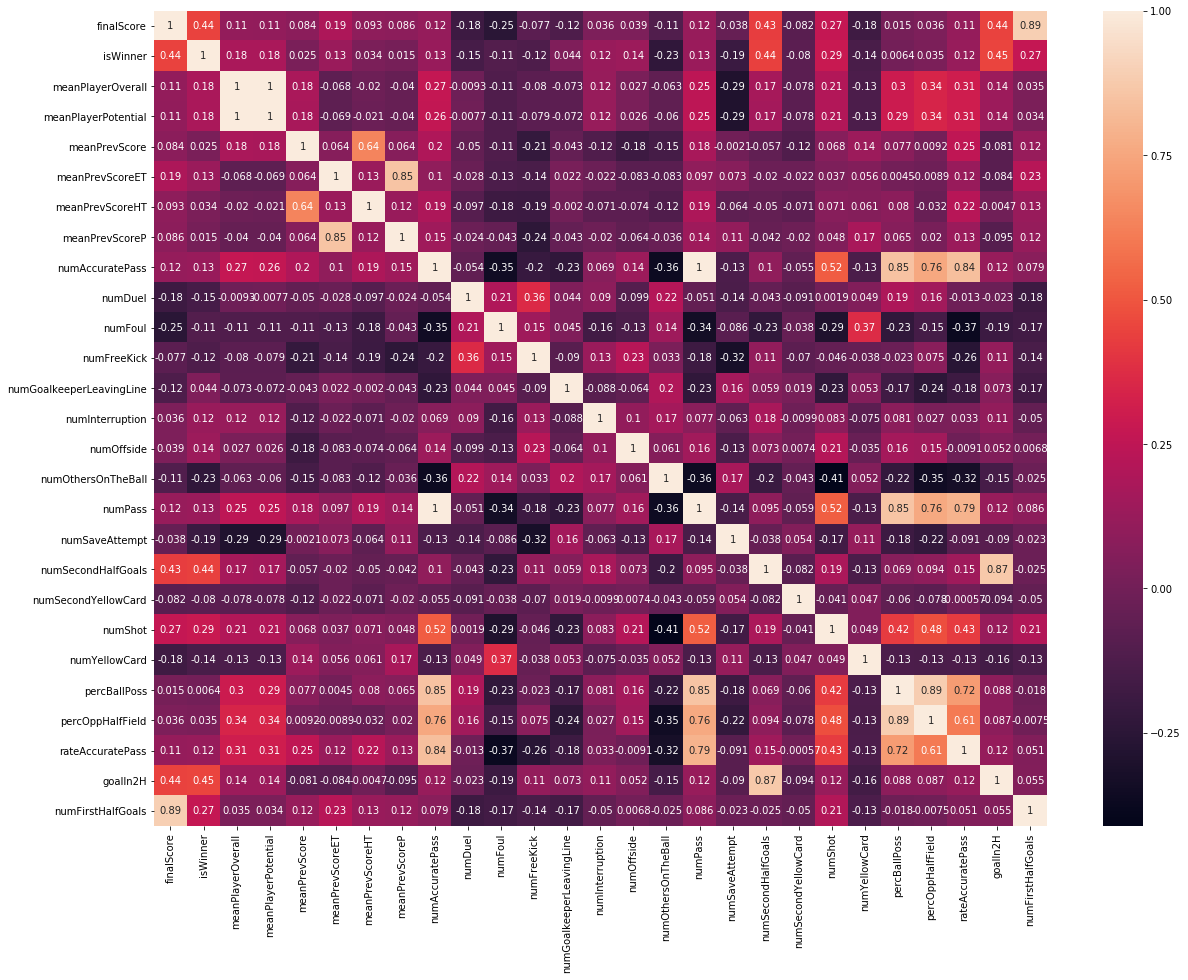

In [56]:
corr = res.drop(['teamId', 'matchId', 'numRedCard'], axis=1).corr()
plt.subplots(figsize =(20, 15))
hm = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

### Scatter matrix

In [58]:
sm = scatter_matrix(res.drop(['teamId', 'matchId', 'numRedCard', 'isWinner', ['numFirstHalfGoals']], axis=1), alpha=0.6, figsize=(20, 20), diagonal='hist')

TypeError: unhashable type: 'list'

### Scatter plots

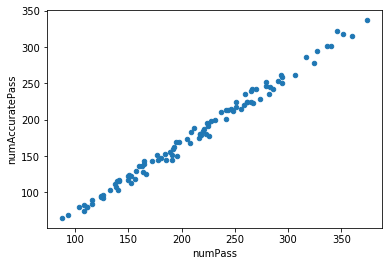

In [28]:
results.plot.scatter(y='numAccuratePass', x='numPass')

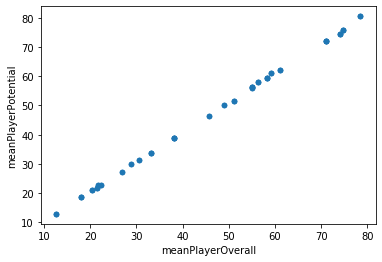

In [30]:
results.plot.scatter(y='meanPlayerPotential', x='meanPlayerOverall')

### Histogram

In [37]:
def plot_histogram_per_attribute(df, att, size):
    fig = plt.figure(figsize=(size, size)) 
    fig_dims = (2, 2)
    
    plt.subplot2grid(fig_dims, (0, 0)) #(0,1), (1,0) (1,1)
    plt.hist(df[att], alpha=0.5, #bins=20, normed=True, 
         histtype='stepfilled', color='steelblue',
         edgecolor='none')
    plt.title(att.title() + ' Histogram')
    
    plt.show()
    #plt.savefig("/home/daniele/dm-local/age_ba_pa_limit_hist.pdf")


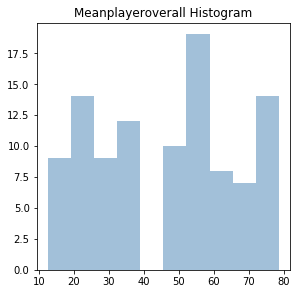

In [38]:
plot_histogram_per_attribute(results, 'meanPlayerOverall', 10 )

### Crosstab

In [59]:
def plot_crosstab_target(df, attribute, target, nB, size):
    crosstab = pd.crosstab(pd.cut(df[attribute], nB), df[target])
    # Normalize the cross tab to sum to 1:
    crosstab_normalized = crosstab.div(crosstab.sum(1).astype(float), axis=0)
    
    crosstab_normalized.plot(kind='bar', stacked=True,
                   title='There is a goal in 2HT by ' + str(attribute) )
    
    plt.show()
    #plt.savefig("/home/daniele/dm-local/ps-default" + str(attribute) + ".pdf")

In [19]:
def plot_crosstab_and_hist(df, att, target, nB, size):
    #fig = plt.figure(figsize=(size, size)) 
    plt.hist(df[att], bins=nB, alpha=0.5, #bins=20, normed=True, 
         rwidth=0.5)
    plt.title(att.title() + ' Histogram')
    
    crosstab = pd.crosstab(pd.cut(df[att], nB), df[target])
    # Normalize the cross tab to sum to 1:
    crosstab_normalized = crosstab.div(crosstab.sum(1).astype(float), axis=0)
    
    crosstab_normalized.plot(kind='bar', stacked=True,
                   title='There is a goal in 2HT by ' + str(att) )
    
    plt.show()
    #plt.savefig("/home/daniele/dm-local/age_ba_pa_limit_hist.pdf")

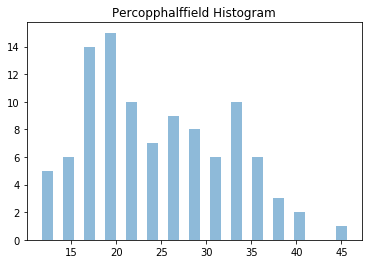

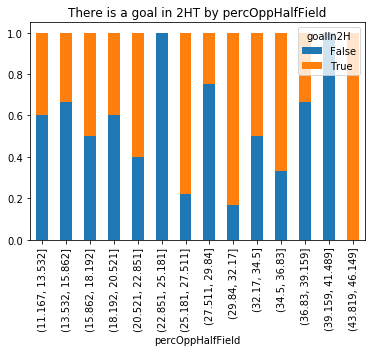

In [26]:
plot_crosstab_and_hist(res, 'percOppHalfField', 'goalIn2H', 15, 10)

### Features importance

In [49]:
def plot_features_importance (X, y, n = len(X.columns) ):
    model = ExtraTreesClassifier()
    model.fit(X,y)
    print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
    #plot graph of feature importances for better visualization
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(n).plot(kind='barh')
    plt.show()

/Users/martincastellani/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.07215482 0.04186315 0.03996754 0.00321069 0.03309642 0.00922218
 0.05585193 0.0819659  0.06854041 0.0532617  0.04292714 0.00113614
 0.0479604  0.04520083 0.03299306 0.04314619 0.0061379  0.08288399
 0.05470312 0.05485311 0.03489429 0.04605231 0.04797679]


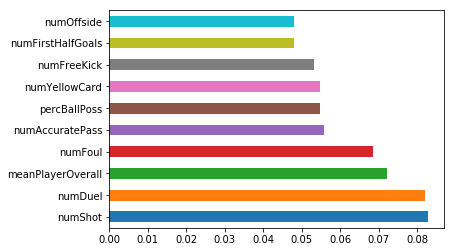

/Users/martincastellani/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.0640282  0.04833314 0.02341702 0.01286021 0.05048183 0.00833772
 0.05139572 0.04535593 0.04133602 0.06608827 0.03081356 0.00569909
 0.03213045 0.06190167 0.05110162 0.05219483 0.00400983 0.07009922
 0.02213694 0.05661182 0.04421032 0.04701781 0.11043878]


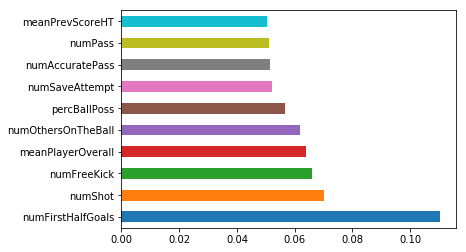

In [62]:
plot_features_importance( res.drop(['teamId', 'matchId', 'numRedCard', 'isWinner', 'goalIn2H', 'numSecondHalfGoals', 'finalScore'], axis=1),
                         res['goalIn2H'], 10)
plot_features_importance( res.drop(['teamId', 'matchId', 'numRedCard', 'isWinner', 'goalIn2H', 'numSecondHalfGoals', 'finalScore'], axis=1),
                         res['isWinner'], 10)

/Users/martincastellani/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.03456226 0.0440855  0.04338052 0.01443694 0.02652701 0.00123387
 0.0608484  0.04948056 0.03342425 0.06504884 0.04249674 0.00751636
 0.05091002 0.06878014 0.04818059 0.07323129 0.00126803 0.0592753
 0.02849508 0.04524446 0.04069678 0.05531513 0.10556191]


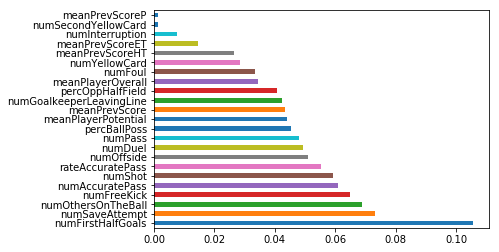